In [1]:
import pandas as pd
import matplotlib.pyplot as plt

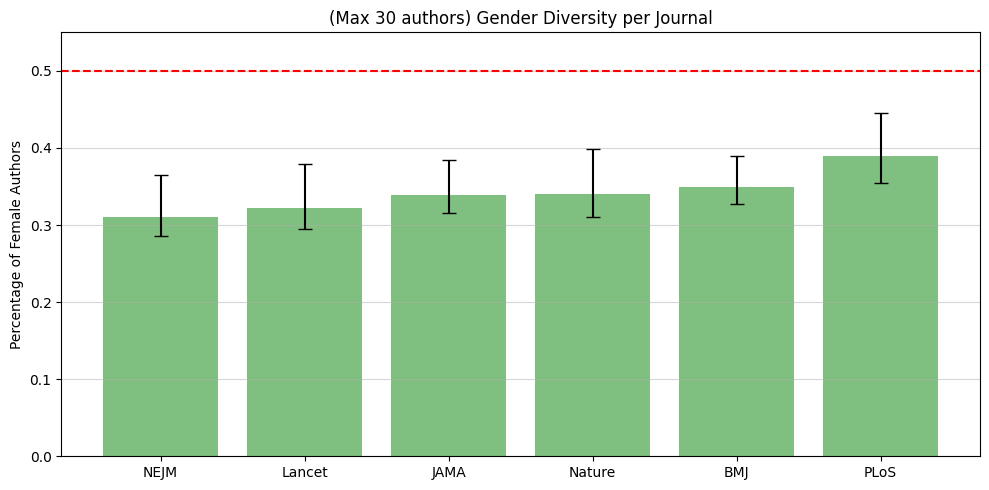

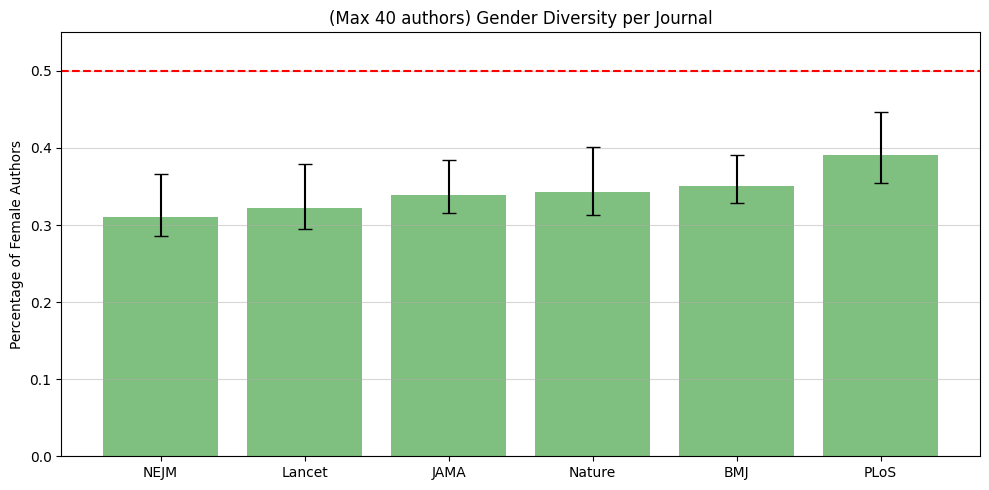

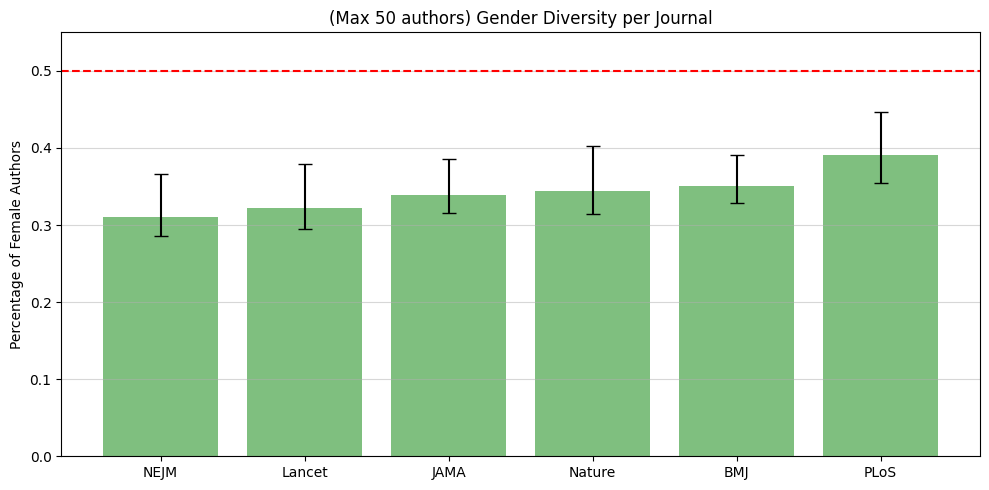

In [59]:
maxs = [30, 40, 50]

for max_ in maxs:
    scenarios = ["clean", "clean/gender_opti", "clean/gender_pessi"]
    columns = ["normal", "optimistic", "pessimistic"]

    # initialize an empty DataFrame
    gender_diversity = pd.DataFrame()

    for sce, col in zip(scenarios, columns):
        df = pd.read_csv(f"data_light/{sce}/max_{max_}_authors" ".csv")
        
        journal_dict = {} # Initialize a dictionary to store the percentage of female authors for each journal
        for journal in df.journal.unique():
            df_j = df[df.journal == journal]
            pct_female = df_j.gender.value_counts(normalize=True)[1]
            journal_dict[journal] = pct_female

        # create a temporary dataframe from the dictionary
        temp_df = pd.DataFrame.from_dict(journal_dict, orient='index', columns=[col])

        if gender_diversity.empty:
            # if the main dataframe is still empty (i.e., this is the first iteration), copy the temporary one
            gender_diversity = temp_df
        else:
            # else, join the new data with the existing dataframe
            gender_diversity = gender_diversity.join(temp_df)

    # sort the dataframe by the normal column
    gender_diversity = gender_diversity.sort_values(by='normal', ascending=True)

    # rename index names
    gender_diversity.index = gender_diversity.index.map({"New England Journal of Medicine": "NEJM",
                                                        "PLOS Medicine": "PLoS",
                                                        "The Lancet": "Lancet",
                                                        "JAMA": "JAMA",
                                                        "The BMJ": "BMJ",
                                                        "Nature Medicine": "Nature"})

    # Calculate error bars
    gender_diversity['lower_error'] = gender_diversity['normal'] - gender_diversity['pessimistic']
    gender_diversity['upper_error'] = gender_diversity['optimistic'] - gender_diversity['normal']
    errors = [gender_diversity['lower_error'], gender_diversity['upper_error']]

    # Plot
    plt.figure(figsize=[10,5])
    plt.bar(gender_diversity.index, gender_diversity['normal'], yerr=errors,
            color='green', align='center', alpha=0.5, ecolor='black', capsize=5, linewidth=1)
    plt.xticks(rotation='vertical')
    plt.ylabel('Percentage of Female Authors')
    plt.title(f'(Max {max_} authors) Gender Diversity per Journal')
    plt.ylim(0, .55)
    plt.axhline(y=0.5, color='r', linestyle='--')
    plt.grid(axis='y', alpha=0.5)
    plt.xticks(rotation=0)


    plt.tight_layout()
    plt.show()


In [77]:
print("6 journals, with PLOS Medicine")
# Agglomerate results
maxs = [30, 40, 50]

for max_ in maxs:
    scenarios = ["clean", "clean/gender_opti", "clean/gender_pessi"]
    columns = ["normal", "optimistic", "pessimistic"]

    # initialize an empty DataFrame
    gender_diversity = pd.DataFrame()

    for sce, col in zip(scenarios, columns):
        df = pd.read_csv(f"data_light/{sce}/max_{max_}_authors" ".csv")
        
        pct_female = df.gender.value_counts(normalize=True)[1]*100

        # create a temporary dataframe from the dictionary
        temp_df = pd.DataFrame.from_dict({'all': pct_female}, orient='index', columns=[col])

        if gender_diversity.empty:
            # if the main dataframe is still empty (i.e., this is the first iteration), copy the temporary one
            gender_diversity = temp_df
        else:
            # else, join the new data with the existing dataframe
            gender_diversity = gender_diversity.join(temp_df)
    
    print(f"Max {max_} authors: {gender_diversity.loc['all'].normal:.2f} ({gender_diversity.loc['all'].pessimistic:.2f} - {gender_diversity.loc['all'].optimistic:.2f}) %")



6 journals, with PLOS Medicine
Max 30 authors: 33.60 (30.97 - 38.79) %
Max 40 authors: 33.67 (31.02 - 38.90) %
Max 50 authors: 33.73 (31.06 - 38.98) %


In [74]:
print("5 journals, without PLOS Medicine")

# Agglomerate results
maxs = [30, 40, 50]

for max_ in maxs:
    scenarios = ["clean", "clean/gender_opti", "clean/gender_pessi"]
    columns = ["normal", "optimistic", "pessimistic"]

    # initialize an empty DataFrame
    gender_diversity = pd.DataFrame()

    for sce, col in zip(scenarios, columns):
        df = pd.read_csv(f"data_light/{sce}/max_{max_}_authors" ".csv")
        df = df[df.journal != "PLOS Medicine"]
        
        pct_female = df.gender.value_counts(normalize=True)[1]*100

        # create a temporary dataframe from the dictionary
        temp_df = pd.DataFrame.from_dict({'all': pct_female}, orient='index', columns=[col])

        if gender_diversity.empty:
            # if the main dataframe is still empty (i.e., this is the first iteration), copy the temporary one
            gender_diversity = temp_df
        else:
            # else, join the new data with the existing dataframe
            gender_diversity = gender_diversity.join(temp_df)
    
    print(f"Max {max_} authors: {gender_diversity.loc['all'].normal:.2f} ({gender_diversity.loc['all'].pessimistic:.2f} - {gender_diversity.loc['all'].optimistic:.2f}) %")



5 journals, without PLOS Medicine
Max 30 authors: 33.09 (30.55 - 38.24) %
Max 40 authors: 33.17 (30.60 - 38.36) %
Max 50 authors: 33.23 (30.64 - 38.43) %


In [32]:
print("6 separate journals")

maxs = [30, 40, 50]
scenarios = ["clean", "clean/lmic_opti", "clean/lmic_pessi"]
columns = ["normal", "optimistic", "pessimistic"]

# Initialize an empty list to store the data
data = []

# Iterate over each maximum
for max_ in maxs:
    # Iterate over each scenario and column
    for sce, col in zip(scenarios, columns):
        # Load the data
        df = pd.read_csv(f"data_light/{sce}/max_{max_}_authors" ".csv")
        
        # Iterate over each unique journal
        for journal in df.journal.unique():
            # Filter the data for the current journal
            df_j = df[df.journal == journal]
            
            # Group by paper and get count and sum of LMIC in different columns
            df_papers = df_j.groupby('pub_id').agg({'LMIC': ['count', 'sum']})
            df_papers['all_LMIC'] = df_papers.apply(lambda row: row.LMIC['count'] == row.LMIC['sum'], axis=1)
            df_papers['all_HIC'] = df_papers.apply(lambda row: row.LMIC['sum'] == 0, axis=1)
            df_papers['mix_LMIC_HIC'] = df_papers.apply(lambda row: row.LMIC['count'] != row.LMIC['sum'], axis=1)

            # Calculate the percentages
            pct_all_HIC = df_papers.all_HIC.value_counts(normalize=True).loc[True] * 100
            pct_all_LMIC = df_papers.all_LMIC.value_counts(normalize=True).loc[True] * 100
            pct_mix_LMIC_HIC = 100 - pct_all_HIC - pct_all_LMIC

            # Append the data to the list
            data.append([max_, col, journal, pct_all_LMIC, pct_all_HIC, pct_mix_LMIC_HIC])

# Convert the list to a DataFrame
df_final = pd.DataFrame(data, columns=['max', 'scenario', 'journal', 'pct_all_LMIC', 'pct_all_HIC', 'pct_mix_LMIC_HIC'])

# rename index names
df_final.journal = df_final.journal.map({"New England Journal of Medicine": "NEJM",
                                       "PLOS Medicine": "PLoS",
                                       "The Lancet": "Lancet",
                                       "JAMA": "JAMA",
                                       "The BMJ": "BMJ",
                                       "Nature Medicine": "Nature"})


6 separate journals


In [6]:
df_final

,max,scenario,journal,pct_all_LMIC,pct_all_HIC,pct_mix_LMIC_HIC
0,30,normal,JAMA,1.608335,93.576775,4.814890
1,30,normal,Lancet,8.304878,72.548780,19.146341
2,30,normal,BMJ,2.787214,90.375403,6.837384
3,30,normal,NEJM,4.781404,88.522221,6.696375
4,30,normal,PLoS,3.004847,61.647819,35.347334
5,30,normal,Nature,1.867894,88.142934,9.989172
6,30,optimistic,JAMA,1.608335,89.146267,9.245398
7,30,optimistic,Lancet,8.304878,72.500000,19.195122
8,30,optimistic,BMJ,2.787214,88.049821,9.162965
9,30,optimistic,NEJM,4.781404,81.572925,13.645670


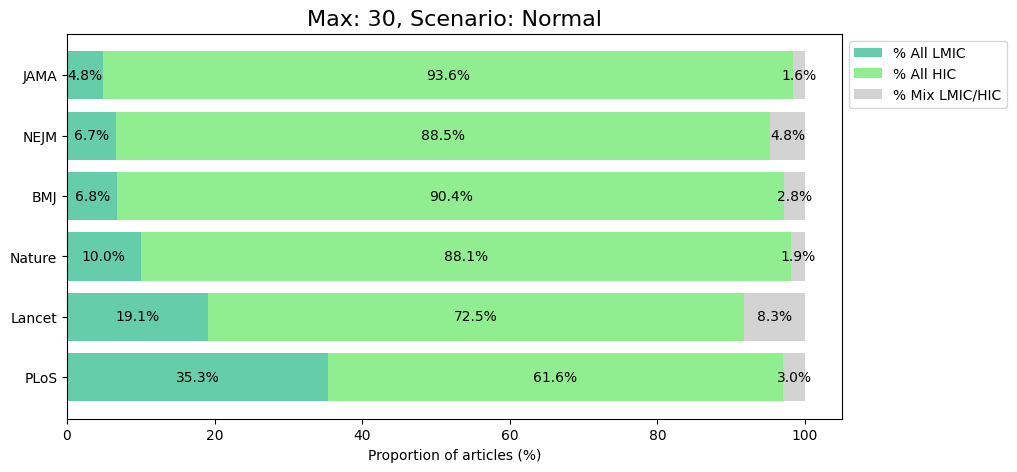

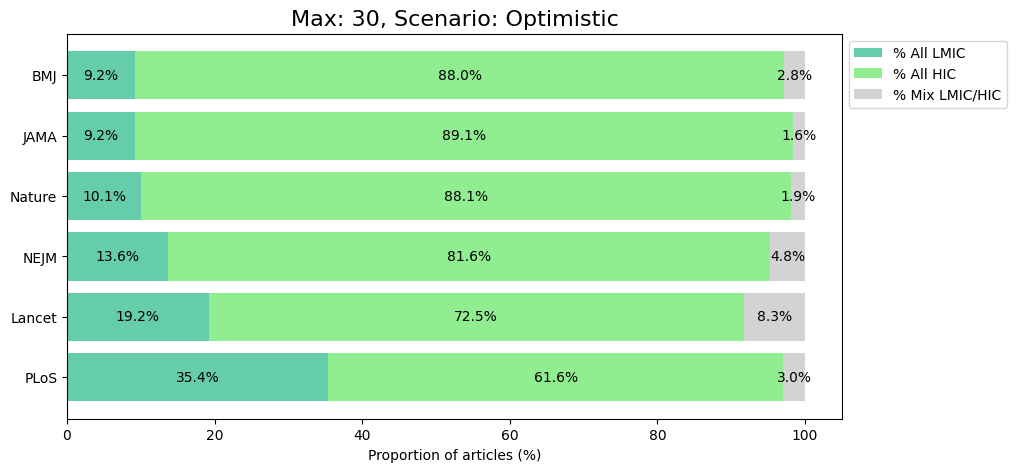

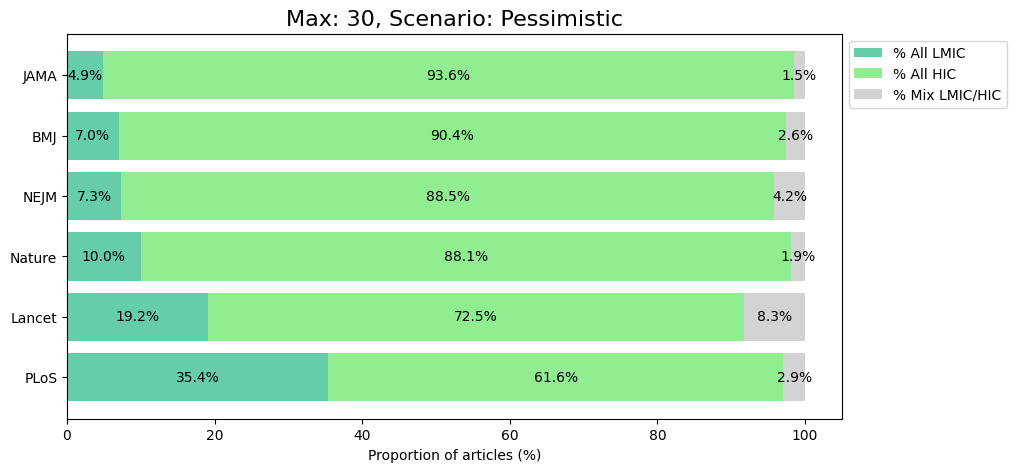

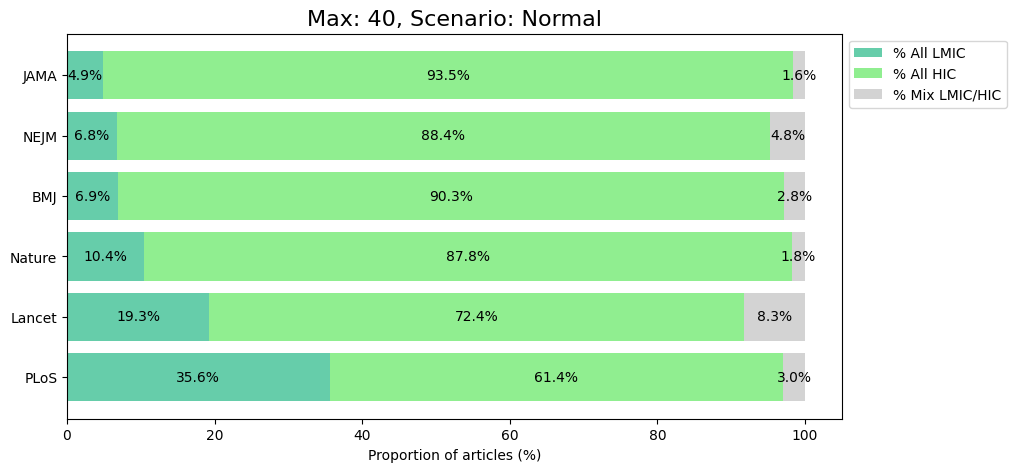

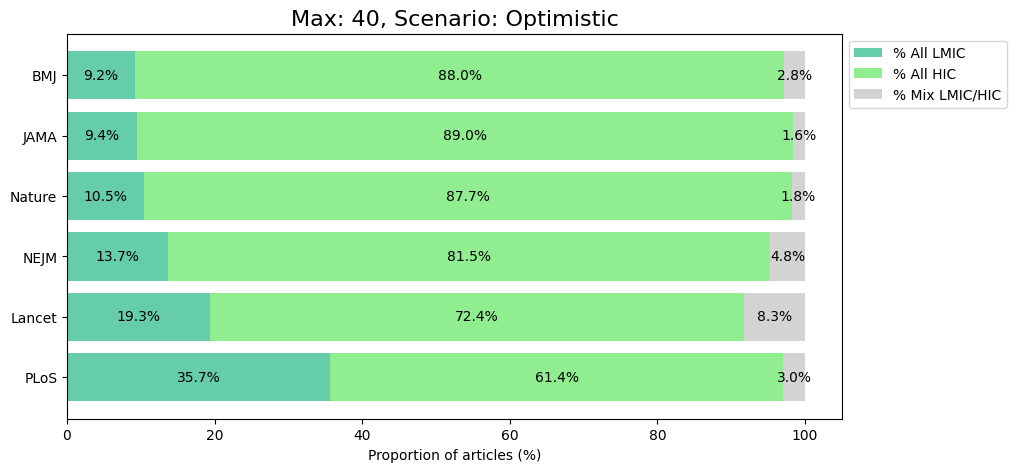

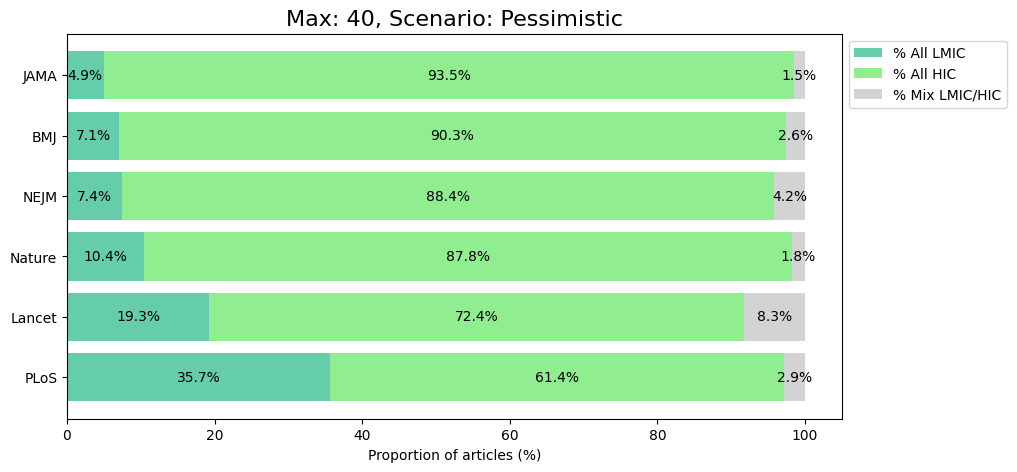

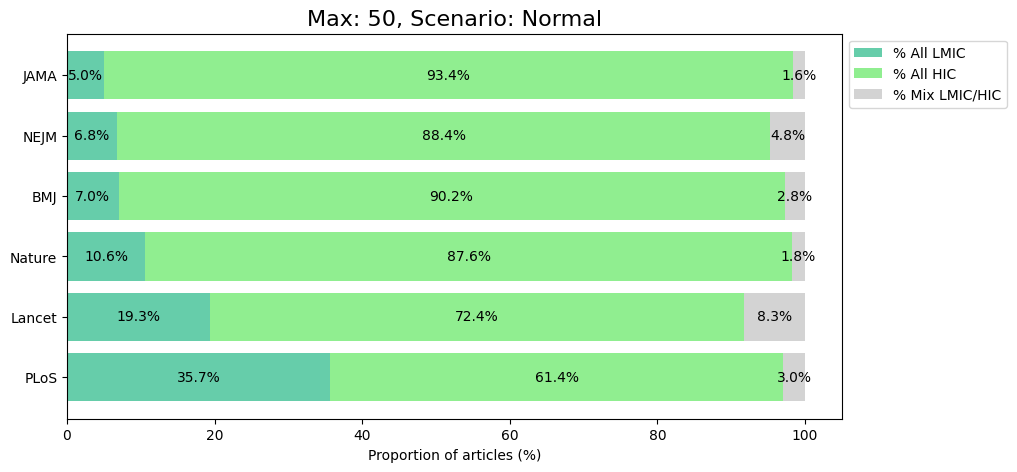

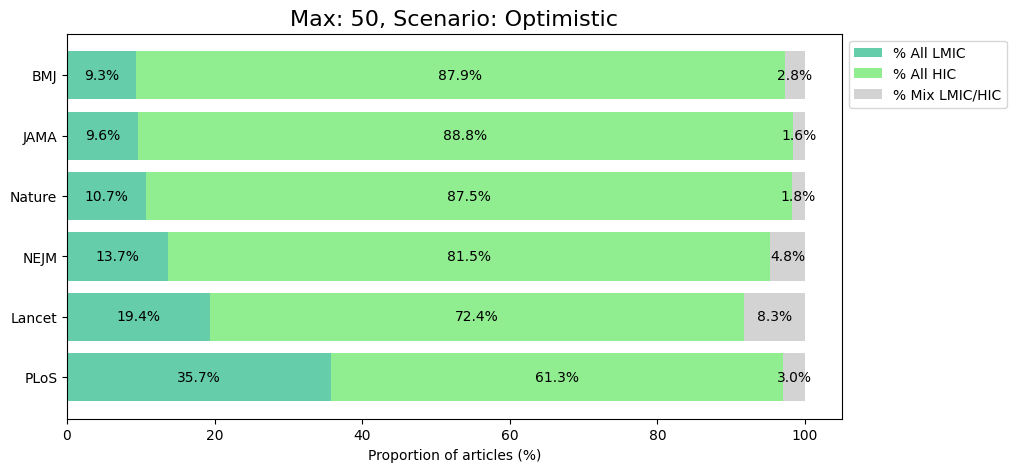

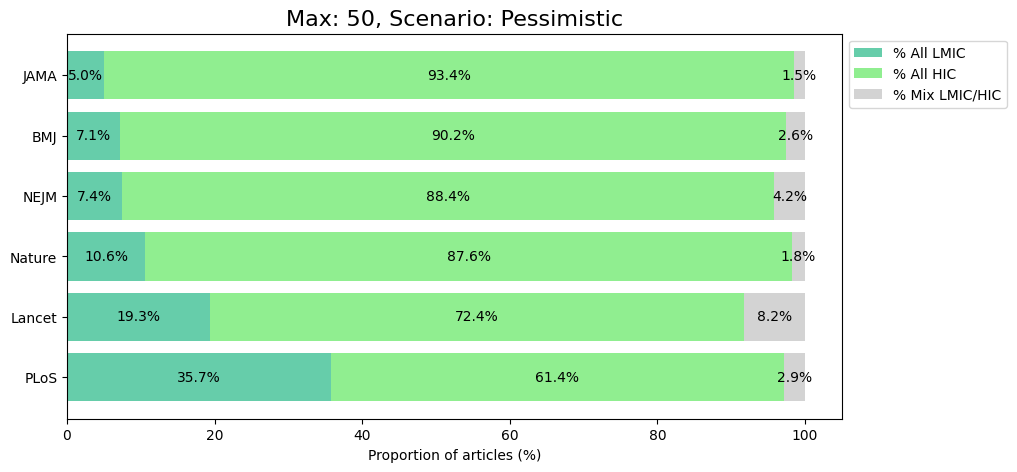

In [35]:
import matplotlib.pyplot as plt

colors = ['mediumaquamarine', 'lightgreen', 'lightgrey']

# Get the unique max values and scenarios
maxs = df_final['max'].unique()
scenarios = df_final['scenario'].unique()

# Iterate over each unique max value
for max_ in maxs:
    # Filter the data for the current max value
    df_max = df_final[df_final['max'] == max_]
    
    # Iterate over each unique scenario
    for scenario in scenarios:
        # Filter the data for the current scenario
        df_scenario = df_max[df_max['scenario'] == scenario].sort_values(by='pct_mix_LMIC_HIC', ascending=False)
        
        
        # Get the unique journals for the current max value and scenario
        journals = df_scenario['journal'].unique()

        # Create a figure and axes
        fig, ax = plt.subplots(figsize=(10, 5))

        # Iterate over each unique journal
        for i, journal in enumerate(journals):
            # Filter the data for the current journal
            df_journal = df_scenario[df_scenario['journal'] == journal]

            vars_ordered = ['pct_all_LMIC', 'pct_all_HIC', 'pct_mix_LMIC_HIC'][::-1]
           
            # Calculate the cumulative sum of the percentages for the stacked bar
            cumsum = df_journal[vars_ordered].cumsum(axis=1)
            
            # Iterate over each column (i.e., each part of the stack)
            for j, column in enumerate(df_journal[vars_ordered].columns):
                # Create the bar
                ax.barh(i, df_journal[column], left=cumsum[column] - df_journal[column], color=colors[j])
                # add text annotation with percentage values to the middle of the bar
                ax.text(cumsum[column] - df_journal[column] + df_journal[column] / 2, i, f'{df_journal[column].iloc[0]:.1f}%', ha='center', va='center', color='black', fontsize=10)


        # Set the y-ticks to be the journal names
        ax.set_yticks(range(len(journals)))
        ax.set_yticklabels(journals)

        # Set the x-label
        ax.set_xlabel('Proportion of articles (%)')

        # Add a title with formatting
        ax.set_title(f'Max: {max_}, Scenario: {scenario.title()}', fontsize=16)

        # Add a legend
        ax.legend(['% All LMIC', '% All HIC', '% Mix LMIC/HIC'], loc='upper left', bbox_to_anchor=(1, 1))

        # save the plots
        plt.savefig(f"results/geographic//{max_}_{scenario}.png", bbox_inches='tight')


In [40]:
print("6 journals, with PLOS Medicine")

maxs = [30, 40, 50]
scenarios = ["clean", "clean/lmic_opti", "clean/lmic_pessi"]
columns = ["normal", "optimistic", "pessimistic"]

# Initialize an empty list to store the data
data = []

# Iterate over each maximum
for max_ in maxs:
    # Iterate over each scenario and column
    for sce, col in zip(scenarios, columns):
        # Load the data
        df = pd.read_csv(f"data_light/{sce}/max_{max_}_authors" ".csv")
        
        # Group by paper and get count and sum of LMIC in different columns
        df_papers = df.groupby('pub_id').agg({'LMIC': ['count', 'sum']})
        df_papers['all_LMIC'] = df_papers.apply(lambda row: row.LMIC['count'] == row.LMIC['sum'], axis=1)
        df_papers['all_HIC'] = df_papers.apply(lambda row: row.LMIC['sum'] == 0, axis=1)
        df_papers['mix_LMIC_HIC'] = df_papers.apply(lambda row: row.LMIC['count'] != row.LMIC['sum'], axis=1)

        # Calculate the percentages
        pct_all_HIC = df_papers.all_HIC.value_counts(normalize=True).loc[True] * 100
        pct_all_LMIC = df_papers.all_LMIC.value_counts(normalize=True).loc[True] * 100
        pct_mix_LMIC_HIC = 100 - pct_all_HIC - pct_all_LMIC

        # Append the data to the list
        data.append([max_, col, pct_all_LMIC, pct_all_HIC, pct_mix_LMIC_HIC])

# Convert the list to a DataFrame
df_final = pd.DataFrame(data, columns=['max', 'scenario', 'pct_all_LMIC', 'pct_all_HIC', 'pct_mix_LMIC_HIC'])

df_final


6 journals, with PLOS Medicine


,max,scenario,pct_all_LMIC,pct_all_HIC,pct_mix_LMIC_HIC
0,30,normal,4.540381,83.314100,12.145519
1,30,optimistic,4.540381,80.864186,14.595433
2,30,pessimistic,4.392819,83.314100,12.293082
3,40,normal,4.515547,83.202993,12.281460
4,40,optimistic,4.515547,80.742189,14.742264
5,40,pessimistic,4.368914,83.202993,12.428093
6,50,normal,4.504285,83.143623,12.352092
7,50,optimistic,4.504285,80.668329,14.827386
8,50,pessimistic,4.358018,83.143623,12.498359


In [39]:
print("5 journals, without PLOS Medicine")

maxs = [30, 40, 50]
scenarios = ["clean", "clean/lmic_opti", "clean/lmic_pessi"]
columns = ["normal", "optimistic", "pessimistic"]

# Initialize an empty list to store the data
data = []

# Iterate over each maximum
for max_ in maxs:
    # Iterate over each scenario and column
    for sce, col in zip(scenarios, columns):
        # Load the data
        df = pd.read_csv(f"data_light/{sce}/max_{max_}_authors" ".csv")
        df = df[df.journal != "PLOS Medicine"]
        
        # Group by paper and get count and sum of LMIC in different columns
        df_papers = df.groupby('pub_id').agg({'LMIC': ['count', 'sum']})
        df_papers['all_LMIC'] = df_papers.apply(lambda row: row.LMIC['count'] == row.LMIC['sum'], axis=1)
        df_papers['all_HIC'] = df_papers.apply(lambda row: row.LMIC['sum'] == 0, axis=1)
        df_papers['mix_LMIC_HIC'] = df_papers.apply(lambda row: row.LMIC['count'] != row.LMIC['sum'], axis=1)

        # Calculate the percentages
        pct_all_HIC = df_papers.all_HIC.value_counts(normalize=True).loc[True] * 100
        pct_all_LMIC = df_papers.all_LMIC.value_counts(normalize=True).loc[True] * 100
        pct_mix_LMIC_HIC = 100 - pct_all_HIC - pct_all_LMIC

        # Append the data to the list
        data.append([max_, col, pct_all_LMIC, pct_all_HIC, pct_mix_LMIC_HIC])

# Convert the list to a DataFrame
df_final = pd.DataFrame(data, columns=['max', 'scenario', 'pct_all_LMIC', 'pct_all_HIC', 'pct_mix_LMIC_HIC'])

df_final


5 journals, without PLOS Medicine


,max,scenario,pct_all_LMIC,pct_all_HIC,pct_mix_LMIC_HIC
0,30,normal,4.635881,84.661603,10.702516
1,30,optimistic,4.635881,82.063339,13.300780
2,30,pessimistic,4.483161,84.661603,10.855237
3,40,normal,4.611728,84.562994,10.825278
4,40,optimistic,4.611728,81.952545,13.435727
5,40,pessimistic,4.459934,84.562994,10.977071
6,50,normal,4.601068,84.507014,10.891918
7,50,optimistic,4.601068,81.880679,13.518253
8,50,pessimistic,4.449625,84.507014,11.043360
